In [1]:
import torch
import numpy as np
import pandas as pd
from collections import Counter 
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import sentence_bleu
from queue import PriorityQueue
import operator

In [2]:
!nvidia-smi

Thu Sep  2 18:15:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:51:00.0 Off |                  N/A |
|  0%   32C    P5    13W / 250W |   5958MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:CB:00.0 Off |                  N/A |
|  0%   33C    P8    10W / 250W |   9447MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
device= torch.device("cuda:2" if torch.cuda.is_available() else "cpu") #"cuda:2" if torch.cuda.is_available() else
DATA_PATH = 'Flicker/'

In [4]:
df = pd.read_csv(DATA_PATH + "captions.txt", sep=',')

In [5]:
def build_caption(caption):
    return ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>']

df['cleaned_caption'] = df['caption'].apply(build_caption)

In [6]:
def remove_empty(word_list):
    lst = []
    for word in word_list:
        if len(word)>=1:
            lst.append(word)
    return lst

df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_empty(x))

In [7]:
max_seq_len = df['cleaned_caption'].apply(lambda x : len(x)).max()
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)))
print(f"The maximum length of the captions is: {max_seq_len}")

word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)

vocab_size = len(word_dict)
# 8372
print(f"Vocabulary size is:{vocab_size}")

The maximum length of the captions is: 36
Vocabulary size is:8372


In [8]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))
#8372 8372

8372 8372


In [9]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [10]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
unq_train_imgs = train[['image']].drop_duplicates()

valid = df.iloc[int(0.9*len(df)):]
unq_valid_imgs = valid[['image']].drop_duplicates()

In [11]:
class imageDataset():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = DATA_PATH + 'Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [12]:
train_ImageDataset= imageDataset(unq_train_imgs)
train_ImageDataloader= DataLoader(train_ImageDataset, batch_size = 8, shuffle=False)

In [13]:
valid_ImageDataset= imageDataset(unq_valid_imgs)
valid_ImageDataloader= DataLoader(valid_ImageDataset, batch_size = 8, shuffle=False)

In [14]:
# resnet34 = torchvision.models.resnet34(pretrained=True).to(device)
# resnet34.eval()
# print(list(resnet34._modules))

In [15]:
# def get_vector(t_img):
#     t_img = Variable(t_img)
#     my_embedding = torch.zeros(1, 512, 7, 7)
#     def copy_data(m, i, o):
#         # print(o.data.shape)
#         my_embedding.copy_(o.data)
#     h = layer.register_forward_hook(copy_data)
#     resnet34(t_img)
#     h.remove()
#     return my_embedding

In [16]:
# layer = resnet34._modules.get('layer4').to(device)

In [17]:
# imgsFeature_train = {}
# for image_name, t_img in tqdm(train_ImageDataloader):
#     t_img = t_img.to(device)
#     embdg = get_vector(t_img)
    
#     imgsFeature_train[image_name[0]] = embdg

In [18]:
# a_file = open(DATA_PATH + "EncodedImageTrainResNet.pkl", "wb")
# pickle.dump(imgsFeature_train, a_file)
# a_file.close()

In [19]:
# imgsFeature_val = {}
# for image_name, t_img in tqdm(valid_ImageDataloader):
#     t_img = t_img.to(device)
#     embdg = get_vector(t_img)
 
#     imgsFeature_val[image_name[0]] = embdg

In [20]:
# a_file = open(DATA_PATH + "EncodedImageValidResNet.pkl", "wb")
# pickle.dump(imgsFeature_val, a_file)
# a_file.close()

In [21]:
class EncodedImageDataset(Dataset):
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]
        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view, image_name

In [22]:
train_encodedDataset = EncodedImageDataset(train, DATA_PATH + 'EncodedImageTrainResNet.pkl')
train_encodedDataloader = DataLoader(train_encodedDataset, batch_size = 32, shuffle=True)

In [23]:
valid_encodedDataset = EncodedImageDataset(valid, DATA_PATH + 'EncodedImageValidResNet.pkl')
valid_encodedDataloader = DataLoader(valid_encodedDataset, batch_size = 32, shuffle=True)

In [24]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)

        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha, attention_weights
        

In [25]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        return self.logp / float(self.leng - 1 + 1e-6)
    
    def __lt__(self, other):
        return self.eval() < other.eval()

In [26]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3, max_seq_len=max_seq_len):
        super().__init__()
        
        #save the model param
        self.max_seq_len= max_seq_len
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    def forward_step(self, decoder_input, encoder_outputs, last_hidden, last_cell):
        #vectorize the caption
        embeds = self.embedding(decoder_input)
        alpha, context = self.attention(encoder_outputs, last_hidden)
        
        lstm_input = torch.cat((embeds, context), dim=1)
        
        hidden, cell  = self.lstm_cell(lstm_input, (last_hidden, last_cell))

        output = self.fcn(self.drop(hidden))
        
        return output, alpha, hidden, cell
        

    def forward(self, encoder_outputs, decoder_input):
        # Initialize LSTM state
        hidden, cell = self.init_hidden_state(encoder_outputs)  # (batch_size, decoder_dim)
        
        seq_length = len(decoder_input[0]) #Exclude the last one -1 
        batch_size = decoder_input.size(0)
        num_features = encoder_outputs.size(1)
        
        outputs = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            output, alpha, hidden, cell= self.forward_step(decoder_input[:, s], encoder_outputs, hidden, cell)
            outputs[:, s]= output
            alphas[:, s]= alpha
        
        return outputs, alphas
    
    
    def beam_decode(self, encoder_outputs):
 
        # Inference part
        # Given the image features generate the captions
        beam_width = 10
        topk = 1  # how many sentence do you want to generate
        decoded_batch = []

        batch_size = encoder_outputs.size(0)
        decoder_hiddens = self.init_hidden_state(encoder_outputs)

        for idx in range(batch_size):
            decoder_hidden = decoder_hiddens[0][idx].unsqueeze(0) , decoder_hiddens[1][idx].unsqueeze(0)
            encoder_output = encoder_outputs[idx].unsqueeze(0)

            #starting input
            decoder_input = torch.tensor(word_to_index['<start>']).to(device) #view(1,-1)
            decoder_input = torch.LongTensor([decoder_input]).to(device) 
            # Number of sentence to generate
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))
            
            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()

            # start the queue
            nodes.put((-node.eval(), node))
            qsize = 1

            # start beam 
            # 1- get the best node so far
            # 2- run the model on it.
            # 3- add best beam_width word to the queue.
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                score, n = nodes.get()
                decoder_input = n.wordid
                decoder_hidden = n.h  
                
                # reaching the end of the caption.
                if n.wordid.item() == word_to_index['<end>'] and n.prevNode != None:
                    endnodes.append((score, n))

                    # if we reached maximum # of sentences required for each image.
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue
                
                # run the model based on the best node.
                output, alpha, hidden, cell = self.forward_step(decoder_input, encoder_output, decoder_hidden[0], decoder_hidden[1])   
                decoder_hidden = hidden, cell
                
                # Get best beam_width result.
                log_prob, indexes = torch.topk(output, beam_width)
                
                
                # build 
                nextnodes = []
                for new_k in range(beam_width):
                    decoded_t = torch.LongTensor([indexes[0][new_k]]).to(device)  #indexes[0][new_k]#.view(1, -1)
                    log_p = log_prob[0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))
                
                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # choose nbest paths, back trace them
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            decoded_batch.append(utterances)
        return decoded_batch
    
    
    
    def greedy_decode(self, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        hidden, cell = self.init_hidden_state(encoder_outputs)  # (batch_size, decoder_dim)
        decoder_input = torch.tensor(word_to_index['<start>']).to(device) #view(1,-1)
        decoder_input = torch.LongTensor([decoder_input]).to(device)
            
        decoded_batch = []
        for i in range(self.max_seq_len):
            embeds = self.embedding(decoder_input)
            decoder_output, alpha, hidden, cell = self.forward_step(decoder_input, encoder_outputs, hidden, cell)   
            decoder_hidden = hidden, cell
            decoder_output = decoder_output.view(batch_size,-1)
            predicted_word_idx = decoder_output.argmax(dim=1)
            decoded_batch.append(predicted_word_idx.item())
            if index_to_word[predicted_word_idx.item()] == "<end>":
                break
            decoder_input = predicted_word_idx
        return decoded_batch 
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [27]:
class Model(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, features, captions):
        outputs = self.decoder(features, captions)
        return outputs
    

In [37]:
#Hyperparams
embed_size=512
attention_dim=512
encoder_dim=512
decoder_dim=512
learning_rate = 2e-4

In [38]:
#init model
model = Model(embed_size=embed_size,
              vocab_size = vocab_size,
              attention_dim=attention_dim,
              encoder_dim=encoder_dim,
              decoder_dim=decoder_dim).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
EPOCHS= 12
min_val_loss = float('inf')

In [40]:
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = 0
    for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(train_encodedDataloader, desc=f'Epoch {epoch}')):        
        caption_seq, target_seq, image_embed = caption_seq.to(device), target_seq.to(device), image_embed.to(device)
        image_embed = image_embed[:, 0, :, :]

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image_embed, caption_seq)
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), target_seq.reshape(-1))
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        train_epoch_loss += loss.detach().item()

    train_epoch_loss /= len(train_encodedDataloader)
    
    val_epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(valid_encodedDataloader, desc=f'Epoch {epoch}')):
            caption_seq, target_seq, image_embed = caption_seq.to(device), target_seq.to(device), image_embed.to(device)
            image_embed = image_embed[:, 0, :, :]

            # Zero the gradients.
            optimizer.zero_grad()
            # Feed forward
            outputs, attentions = model(image_embed, caption_seq)
            
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), target_seq.reshape(-1))
            
            # add loss
            val_epoch_loss += loss.detach().item()
    
    val_epoch_loss /= len(valid_encodedDataloader) 
    
    print(f'Epoch: {epoch}, Train Loss: {train_epoch_loss}, Validation Loss: {val_epoch_loss}')
    if min_val_loss > val_epoch_loss:
        print(f"Update Model at Epoch :{epoch}")
        torch.save({'state_dict': model.state_dict()}, 'lstm_model.tar')
        min_val_loss = val_epoch_loss

Epoch 0:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 4.2065319522612965, Validation Loss: 3.5638938119092325
Update Model at Epoch :0


Epoch 1:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 3.391766081166393, Validation Loss: 3.2732569589389593
Update Model at Epoch :1


Epoch 2:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 3.099701938394503, Validation Loss: 3.12948655706691
Update Model at Epoch :2


Epoch 3:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 2.902996320087587, Validation Loss: 3.04923959041205
Update Model at Epoch :3


Epoch 4:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 2.744819721982852, Validation Loss: 3.000936862990612
Update Model at Epoch :4


Epoch 5:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 2.610344155601542, Validation Loss: 2.969630256412536
Update Model at Epoch :5


Epoch 6:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 2.4919726337406045, Validation Loss: 2.9521153198452446
Update Model at Epoch :6


Epoch 7:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 2.383862007062339, Validation Loss: 2.936888957586814
Update Model at Epoch :7


Epoch 8:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 2.283327586412011, Validation Loss: 2.9413605111790453


Epoch 9:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 2.19171740709164, Validation Loss: 2.9458623983728605


Epoch 10:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 2.1043143729124423, Validation Loss: 2.954580658064114


Epoch 11:   0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 2.0227607454063605, Validation Loss: 2.9640775440246103


In [43]:
model = Model(embed_size=embed_size,
              vocab_size = vocab_size,
              attention_dim=attention_dim,
              encoder_dim=encoder_dim,
              decoder_dim=decoder_dim).to(device)

In [44]:
checkpoint = torch.load('lstm_model.tar')
model.load_state_dict(checkpoint['state_dict'])
model= model.to(device)

In [45]:
#generate caption
def show_caption(model, img_name, encoder_outputs):
    Image.open(DATA_PATH +'Images/' +img_name).show()
    
    #generate the caption
    model.eval()
    with torch.no_grad():
        decoded_batch = model.decoder.greedy_decode(encoder_outputs)
        caption = ' '.join([index_to_word[word] for word in decoded_batch][:-1])
        print(f"Greedy Search caption: {caption}")
        
        decoded_batch = model.decoder.beam_decode(encoder_outputs)
        caption = ' '.join([index_to_word[word.item()] for word in decoded_batch[0][0]][1:-1])
        print(f"Beam Search caption: {caption}")

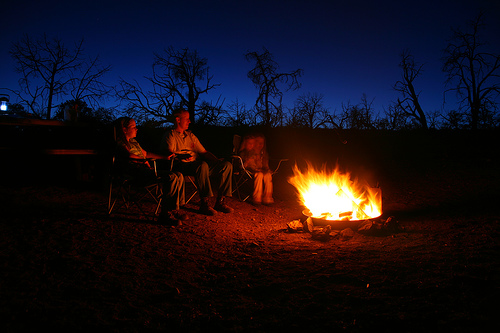

Greedy Search caption: a group of people are sitting at night
Beam Search caption: a group of people sit at night


In [55]:
img_index = 800
_,_, img, img_name = valid_encodedDataset[img_index]
show_caption(model, img_name, img.to(device))

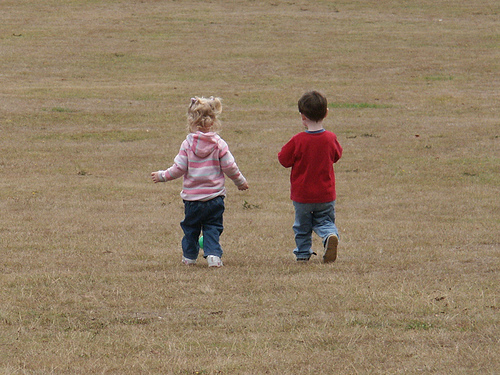

Greedy Search caption: a girl in a pink shirt and a blue shirt runs through the grass
Beam Search caption: a little girl in a pink shirt is running in a field


In [47]:
img_index = 35
_,_, img, img_name = valid_encodedDataset[img_index]
show_caption(model, img_name, img.to(device))

In [48]:
#generate caption
def get_caption_greedy(model, encoder_outputs):
    model.eval()
    with torch.no_grad():
        decoded_batch = model.decoder.greedy_decode(encoder_outputs)
        caption = ' '.join([index_to_word[word] for word in decoded_batch][:-1])
        return caption

In [49]:
#generate caption
def get_caption_beam(model, encoder_outputs):
    model.eval()
    with torch.no_grad():
        decoded_batch = model.decoder.beam_decode(encoder_outputs)
        caption = ' '.join([index_to_word[word.item()] for word in decoded_batch[0][0]][1:-1])
        return caption

In [52]:
def calculate_blue(method=get_caption_greedy):
    blue_1, blue_2, blue_3, blue_4 = 0, 0, 0, 0
    with torch.no_grad():
        for (_, _, image_embed, img_name) in tqdm(valid_encodedDataset):
            references_corpus = list(df[df['image'] == img_name]['caption'])
            references_corpus = [x.split(' ') for x in references_corpus]
            candidate_corpus = [method(model, image_embed.to(device))]
            candidate_corpus = [x.split(' ') for x in candidate_corpus][0]
            blue_1 += sentence_bleu(references_corpus, candidate_corpus, weights=(1, 0, 0, 0))
            blue_2 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.5, 0.5, 0, 0))
            blue_3 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.33, 0.33, 0.33, 0))
            blue_4 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.25, 0.25, 0.25, 0.25))

        blue_1 /= len(valid_encodedDataset)
        blue_2 /= len(valid_encodedDataset)
        blue_3 /= len(valid_encodedDataset)
        blue_4 /= len(valid_encodedDataset)
        print(f"Blue 1 score: {blue_1}",
              f"\nBlue 2 score: {blue_2}",
              f"\nBlue 3 score: {blue_3}",
              f"\nBlue 4 score: {blue_4}")

In [53]:
calculate_blue(get_caption_greedy)

  0%|          | 0/4046 [00:00<?, ?it/s]

Blue 1 score: 0.5302345675047715 
Blue 2 score: 0.335410583289962 
Blue 3 score: 0.1676845779178149 
Blue 4 score: 0.06934847315828485


In [54]:
calculate_blue(get_caption_beam)

  0%|          | 0/4046 [00:00<?, ?it/s]

Blue 1 score: 0.51327491415905 
Blue 2 score: 0.3069280476697683 
Blue 3 score: 0.15841465279581346 
Blue 4 score: 0.0703548932791482
